In [2]:
# .nii 파일 shape, metadata 확인

import nibabel as nib
import numpy as np

file_path = '/nas/research/03-Neural_decoding/3-bids/derivatives/raw_prep_vol/sub-01/brainmask.nii.gz'
img = nib.load(file_path)
data = img.get_fdata()

print(data.shape)

header = img.header
print(header)

(81, 104, 83)
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3  81 104  83   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.  1.8 1.8 1.8 1.  1.  1.  1. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 1
glmin           : 0
descrip         : b''
aux_file        : b'none'
qform_code      : unknown
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
srow_x          : [  1.8   0. 

In [43]:
#.npy 파일 shape 확인

import numpy as np

file_path = '/nas/research/03-Neural_decoding/3-bids/derivatives/beta_huggingface/nsdgeneral_test.npy'
data = np.load(file_path)
print(f"배열의 shape: {data.shape}")
print(data)


배열의 shape: (982, 15724)
[[ 0.4685  -0.3406  -0.107   ... -0.1604   0.5244   0.1628 ]
 [-0.4307  -0.1251  -0.1589  ...  0.8584  -0.05576 -0.3054 ]
 [ 0.6665   0.6816   0.2654  ...  0.561    0.675    0.4456 ]
 ...
 [-0.2766  -0.08405  0.892   ... -0.2181  -0.896   -0.644  ]
 [-0.2634  -1.029    0.0542  ...  0.1042  -0.588   -0.3652 ]
 [-0.8687  -1.439   -0.6455  ... -0.5825  -0.8076  -0.5776 ]]


In [ ]:
import nibabel as nib
import numpy as np

# 파일 경로
beta_path = '/nas/research/03-Neural_decoding/3-bids/derivatives/normalize/sub-01/betas_session03.nii.gz'

# 데이터 로드
beta_img = nib.load(beta_path)
beta_data = beta_img.get_fdata()  # shape: (x, y, z, t)

# t=1 (두 번째 timepoint)의 3D 볼륨
volume_t1 = beta_data[..., 1]  # shape: (x, y, z)

# 값이 0이 아닌 (x, y, z) 좌표의 개수 세기
non_zero_voxel_count = np.count_nonzero(volume_t1)

print(f"✅ t=1에서 intensity가 0이 아닌 복셀 수: {non_zero_voxel_count}")


In [3]:
# beta파일 bids 형식으로 만들기
import os
import re
import shutil

# 원본 루트 폴더
root_dir = "/nas/research/03-Neural_decoding/3-bids/derivatives/b4_roi"
# 새로운 저장 루트 (BIDS 형식으로 저장할 곳)
output_dir = "/nas/research/03-Neural_decoding/3-bids/derivatives/b4_roi2"

os.makedirs(output_dir, exist_ok=True)

for subject_folder in os.listdir(root_dir):
    subject_path = os.path.join(root_dir, subject_folder)
    if os.path.isdir(subject_path) and subject_folder.startswith("sub-"):
        subject_id = subject_folder.split("-")[1]

        for filename in os.listdir(subject_path):
            if filename.startswith("betas_session") and filename.endswith(".nii.gz"):
                session_match = re.search(r'session(\d+)', filename)
                if session_match:
                    session_num = session_match.group(1).zfill(2)
                    desc = "betaroi"  # 파일 이름
                    new_filename = f"sub-{subject_id}_ses-{session_num}_desc-{desc}.nii.gz"

                    bids_sub_dir = os.path.join(output_dir, f"sub-{subject_id}", f"ses-{session_num}", "func")
                    os.makedirs(bids_sub_dir, exist_ok=True)

                    src_file = os.path.join(subject_path, filename)
                    dst_file = os.path.join(bids_sub_dir, new_filename)
                    shutil.copy2(src_file, dst_file)

In [14]:
import nibabel as nib
import numpy as np

# z-score 정규화된 fMRI 파일
zscore_file = '/nas/research/03-Neural_decoding/3-bids/derivatives/new_b4_roi_zscore/sub-01/ses-01/func/sub-01_ses-01_desc-betaroizscore.nii.gz'
# 마스크 파일
mask_file = '/nas/research/03-Neural_decoding/3-bids/derivatives/b4_roi_zscore/sub-01/sub-01_nsdgeneral.nii.gz'

# 데이터 로딩
zdata = nib.load(zscore_file).get_fdata()  # shape: (X, Y, Z, T)
mask = nib.load(mask_file).get_fdata() > 0  # shape: (X, Y, Z), boolean

# 시간축 기준 voxel-wise 평균/표준편차 계산 → shape: (X, Y, Z)
voxel_means = np.mean(zdata, axis=-1)
voxel_stds = np.std(zdata, axis=-1)

# 마스크 영역만 골라서 평균 계산
mean_of_means = np.mean(voxel_means[mask])
mean_of_stds = np.mean(voxel_stds[mask])

print(f"[Voxel-wise] 마스크 영역 평균들의 평균: {mean_of_means:.4f}")
print(f"[Voxel-wise] 마스크 영역 표준편차들의 평균: {mean_of_stds:.4f}")




[Voxel-wise] 마스크 영역 평균들의 평균: 0.0000
[Voxel-wise] 마스크 영역 표준편차들의 평균: 1.0000


In [ ]:
#h5py 파일 압축 풀기

import h5py
import os
import numpy as np

def hdf5_to_folder(hdf5_path, output_dir):
    def recursively_save(h5_obj, current_path):
        for key in h5_obj:
            item = h5_obj[key]
            item_path = os.path.join(current_path, key)
            if isinstance(item, h5py.Dataset):
                # npy로 저장
                np.save(item_path + '.npy', item[()])
            elif isinstance(item, h5py.Group):
                os.makedirs(item_path, exist_ok=True)
                recursively_save(item, item_path)

    with h5py.File(hdf5_path, 'r') as f:
        os.makedirs(output_dir, exist_ok=True)
        recursively_save(f, output_dir)

# 사용 예
hdf5_to_folder(
    hdf5_path='/nas/research/03-Neural_decoding/3-bids/subj01_whole_brain.hdf5',
    output_dir='/nas/research/03-Neural_decoding/3-bids/subj01_whole_brain_extracted'
)

In [49]:
import numpy as np

voxels = np.load('/nas/research/03-Neural_decoding/3-bids/train_subj01_0/sample000000300.coco73k.npy')
print(voxels)


#images = np.load('/nas/research/03-Neural_decoding/3-bids/subj01_nsdgeneral_extracted/images.npy')
#print(images.shape)

[2516]


Shape: (15724,)
Min: -3.752
Max: 3.53
Mean: -0.2416
Std: 0.8574
Median: -0.254


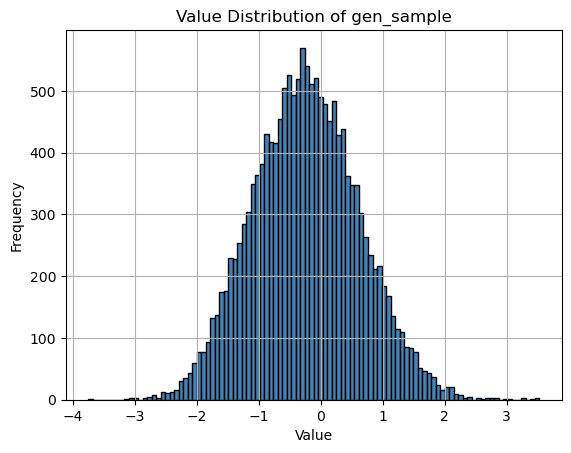

In [2]:
import numpy as np

gen_sample = np.load('/nas/research/03-Neural_decoding/3-bids/train_subj01_0/sample000000300.nsdgeneral.npy')[1]
# gen_sample = np.load('/nas/research/03-Neural_decoding/3-bids/derivatives/b4_roi_new_zscore/sub-01/ses-21/func/sub-01_ses-21_desc-betaroizscore.npy')[329]

print("Shape:", gen_sample.shape)
print("Min:", np.min(gen_sample))
print("Max:", np.max(gen_sample))
print("Mean:", np.mean(gen_sample))
print("Std:", np.std(gen_sample))
print("Median:", np.median(gen_sample))
import matplotlib.pyplot as plt

plt.hist(gen_sample.flatten(), bins=100, color='steelblue', edgecolor='black')
plt.title("Value Distribution of gen_sample")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()



In [ ]:
import numpy as np

# gen_sample = np.load('/nas/research/03-Neural_decoding/3-bids/train_subj01_0/sample000000300.nsdgeneral.npy')[1]
gen_sample = np.load('/nas/research/03-Neural_decoding/3-bids/derivatives/b4_roi_new_zscore/sub-01/ses-21/func/sub-01_ses-21_desc-betaroizscore.npy')[329]
# gen_sample = np.load('/nas/research/03-Neural_decoding/3-bids/derivatives/b4_roi/sub-01/betas_session01.nii.gz')[329]

print("Shape:", gen_sample.shape)
print("Min:", np.min(gen_sample))
print("Max:", np.max(gen_sample))
print("Mean:", np.mean(gen_sample))
print("Std:", np.std(gen_sample))
print("Median:", np.median(gen_sample))
import matplotlib.pyplot as plt

plt.hist(gen_sample.flatten(), bins=100, color='steelblue', edgecolor='black')
plt.title("Value Distribution of gen_sample")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


ValueError: Cannot load file containing pickled data when allow_pickle=False

Shape: (107104,)
Min: -11282.0
Max: 11132.0
Mean: 19.869724753510607
Std: 544.1011689422014
Median: 10.0


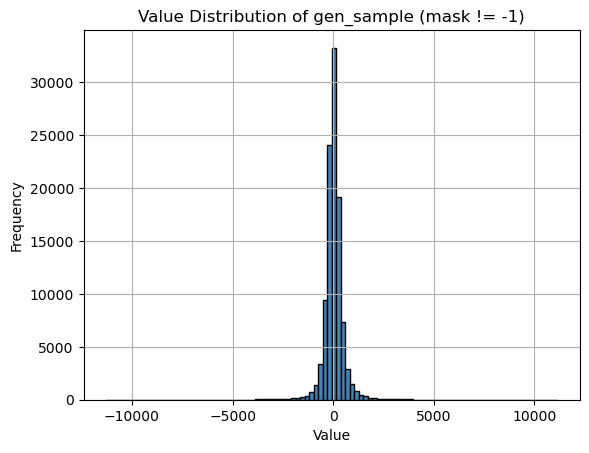

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# 데이터 로드
gen_img = nib.load('/nas/research/03-Neural_decoding/3-bids/derivatives/b4_roi/sub-01/betas_session01.nii.gz')
gen_data = gen_img.get_fdata()
gen_sample = gen_data[..., 329]  # 4D의 329번째 볼륨

# 마스크 로드
mask_img = nib.load('/nas/research/03-Neural_decoding/3-bids/derivatives/b4_roi_zscore/sub-01/sub-01_nsdgeneral.nii.gz')
mask_data = mask_img.get_fdata()

# 마스크 적용: mask가 -1이 아닌 위치만 선택
masked_values = gen_sample[mask_data == 1]

# 통계 출력
print("Shape:", masked_values.shape)
print("Min:", np.min(masked_values))
print("Max:", np.max(masked_values))
print("Mean:", np.mean(masked_values))
print("Std:", np.std(masked_values))
print("Median:", np.median(masked_values))

# 히스토그램 시각화
plt.hist(masked_values.flatten(), bins=100, color='steelblue', edgecolor='black')
plt.title("Value Distribution of gen_sample (mask != -1)")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()



In [5]:
import numpy as np

# pixcorr 함수 정의
def pixcorr(a, b):
    return np.corrcoef(a.flatten(), b.flatten())[0, 1]

# --- 1. fMRI 응답 벡터 불러오기 ---
# (a) ses-36, TR 47
data1 = np.load('/nas/research/03-Neural_decoding/3-bids/derivatives/b4_roi_new_zscore/sub-01/ses-21/func/sub-01_ses-21_desc-betaroizscore.npy')
print(data1.shape)
vec1 = data1[329]  # shape: (15724,)

# (b) ses-37, TR 390
data2 = np.load('/nas/research/03-Neural_decoding/3-bids/derivatives/b4_roi_new_zscore/sub-01/ses-24/func/sub-01_ses-24_desc-betaroizscore.npy')
print(data2.shape)
vec2 = data2[186]
vec3 = data2[329]

# --- 2. 생성 이미지의 feature 벡터 불러오기 ---
gen_sample = np.load('/nas/research/03-Neural_decoding/3-bids/train_subj01_0/sample000000300.nsdgeneral.npy')
print(gen_sample.shape)
# gen_sample shape = (3, 15724) 라면, 각 행이 하나의 샘플 벡터
gen1, gen2, gen3 = gen_sample[0], gen_sample[1], gen_sample[2]

# --- 3. pixcorr 계산 ---
print("pixcorr(vec1, gen1):", pixcorr(vec1, gen1))
print("pixcorr(vec2, gen2):", pixcorr(vec2, gen2))
print("pixcorr(vec3, gen3):", pixcorr(vec3, gen3))


(750, 15724)
(750, 15724)
(3, 15724)
pixcorr(vec1, gen1): -0.24386000123148174
pixcorr(vec2, gen2): -0.2520202925822968
pixcorr(vec3, gen3): -0.2735316386893801


In [33]:
from PIL import Image

img = Image.open('/nas/research/03-Neural_decoding/3-bids/train_subj01_0/sample000000300.jpg')
print("Image size:", img.size)  # (width, height)

img2 = Image.open('/nas/research/03-Neural_decoding/4-image/coco2017_2489.jpg')
print("Image size:", img2.size)  # (width, height)


Image size: (256, 256)
Image size: (425, 425)


In [31]:
import numpy as np
import pandas as pd

# load fMRI feature vectors
fmri_path = '/nas/research/03-Neural_decoding/3-bids/derivatives/beta_huggingface/nsdgeneral.npy'
X = np.load(fmri_path)  # shape: (25611, 15724)

# load image labels
tsv_path = '/nas/research/03-Neural_decoding/3-bids/derivatives/beta_huggingface/mapped_img_train.tsv'
Y = pd.read_csv(tsv_path, sep='\t', header=None).values.squeeze()  # shape: (25611,) 문자열 배열

# check shape consistency
assert X.shape[0] == Y.shape[0], "❌ sample 수가 일치하지 않습니다."

# save to npz
output_path = '/nas/research/03-Neural_decoding/3-bids/derivatives/beta_huggingface/fmri_with_labels.npz'
np.savez(output_path, X=X, Y=Y)

print(f"✅ 저장 완료: {output_path}")
print(f"X shape: {X.shape}, Y shape: {Y.shape}")


✅ 저장 완료: /nas/research/03-Neural_decoding/3-bids/derivatives/beta_huggingface/fmri_with_labels.npz
X shape: (25611, 15724), Y shape: (25611,)


In [33]:
import numpy as np

# .npz 파일 경로
npz_path = '/nas/research/03-Neural_decoding/3-bids/derivatives/beta_huggingface/fmri_with_labels.npz'

# 파일 열기
data = np.load(npz_path, allow_pickle=True)

# key 목록 출력
print("📁 포함된 배열 목록:", data.files)

# X 배열 내용 일부 출력 (fMRI feature vector)
X = data['X']
print("\n🔍 X (fMRI 벡터) 일부:")
print(X[:3])  # 첫 3개 벡터 출력

# Y 배열 내용 일부 출력 (이미지 파일 이름)
Y = data['Y']
print("\n🖼️ Y (이미지 이름) 일부:")
print(Y[:10])  # 첫 10개 출력


📁 포함된 배열 목록: ['X', 'Y']

🔍 X (fMRI 벡터) 일부:
[[-0.4033 -0.6196 -0.931  ...  0.2277 -1.668  -0.5137]
 [ 0.666  -1.306  -0.6562 ...  0.9375 -1.32   -0.949 ]
 [-1.437  -0.5967  0.0484 ...  0.29   -1.243  -1.415 ]]

🖼️ Y (이미지 이름) 일부:
['coco2017_14.jpg' 'coco2017_14.jpg' 'coco2017_14.jpg' 'coco2017_28.jpg'
 'coco2017_28.jpg' 'coco2017_28.jpg' 'coco2017_72.jpg' 'coco2017_72.jpg'
 'coco2017_72.jpg' 'coco2017_86.jpg']


In [28]:
import numpy as np
import os
from glob import glob

base_dir = '/nas/research/03-Neural_decoding/3-bids/derivatives/beta_huggingface'
num_files = sorted(glob(os.path.join(base_dir, 'sample?????????.num_uniques.npy')))

unexpected = []
ones = []

for f in num_files:
    try:
        val = int(np.load(f))
        if val != 3:
            basename = os.path.basename(f)
            unexpected.append((basename, val))
            if val == 1:
                ones.append(basename)
    except Exception as e:
        print(f"❌ 오류 in {f}: {e}")

# 결과 출력
print(f"\n⚠️ 3이 아닌 값이 들어 있는 파일 수: {len(unexpected)}개")
for name, val in unexpected[:20]:
    print(f"{name}: {val}")

print(f"\n🔎 값이 1인 파일 수: {len(ones)}개")
for name in ones[:20]:  # 너무 많으면 일부만 출력
    print(f"{name}")



⚠️ 3이 아닌 값이 들어 있는 파일 수: 1237개
sample000000005.num_uniques.npy: 2
sample000000006.num_uniques.npy: 2
sample000000007.num_uniques.npy: 2
sample000000017.num_uniques.npy: 2
sample000000035.num_uniques.npy: 2
sample000000036.num_uniques.npy: 1
sample000000045.num_uniques.npy: 1
sample000000055.num_uniques.npy: 2
sample000000062.num_uniques.npy: 2
sample000000067.num_uniques.npy: 1
sample000000074.num_uniques.npy: 2
sample000000084.num_uniques.npy: 2
sample000000085.num_uniques.npy: 2
sample000000086.num_uniques.npy: 1
sample000000087.num_uniques.npy: 2
sample000000091.num_uniques.npy: 2
sample000000093.num_uniques.npy: 2
sample000000095.num_uniques.npy: 1
sample000000112.num_uniques.npy: 2
sample000000125.num_uniques.npy: 1

🔎 값이 1인 파일 수: 311개
sample000000036.num_uniques.npy
sample000000045.num_uniques.npy
sample000000067.num_uniques.npy
sample000000086.num_uniques.npy
sample000000095.num_uniques.npy
sample000000125.num_uniques.npy
sample000000142.num_uniques.npy
sample000000191.num_uniqu

In [39]:
import os
import numpy as np
from glob import glob
from tqdm import tqdm

test_dir = '/nas/research/03-Neural_decoding/3-bids/derivatives/beta_huggingface/test'
output_path = '/nas/research/03-Neural_decoding/3-bids/derivatives/beta_huggingface/nsdgeneral_test.npy'

# 모든 nsdgeneral.npy 파일 경로 수집
npy_files = sorted(glob(os.path.join(test_dir, 'sample?????????.nsdgeneral.npy')))

print(f"🔍 총 {len(npy_files)}개의 파일을 검사합니다...")

invalid_files = []
averaged_vectors = []

for f in tqdm(npy_files):
    try:
        arr = np.load(f)
        if arr.shape[0] != 3:
            invalid_files.append((os.path.basename(f), arr.shape))
        else:
            avg = arr.mean(axis=0)  # (15724,)
            averaged_vectors.append(avg)
    except Exception as e:
        invalid_files.append((os.path.basename(f), f"오류: {e}"))

# 유효성 검사 후 처리
if invalid_files:
    print("\n❌ 다음 파일들이 3개의 벡터를 포함하지 않아 병합을 중단합니다:")
    for name, shape in invalid_files[:10]:
        print(f" - {name}: {shape}")
    if len(invalid_files) > 10:
        print(f"... 외 {len(invalid_files) - 10}개 생략됨")
else:
    output_array = np.stack(averaged_vectors, axis=0)
    np.save(output_path, output_array)
    print(f"\n✅ 모든 벡터 평균 완료. 저장 경로: {output_path}")
    print(f"Final shape: {output_array.shape}")


🔍 총 982개의 파일을 검사합니다...


100%|██████████| 982/982 [00:04<00:00, 229.86it/s]



✅ 모든 벡터 평균 완료. 저장 경로: /nas/research/03-Neural_decoding/3-bids/derivatives/beta_huggingface/nsdgeneral_test.npy
Final shape: (982, 15724)


In [41]:
import os
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm

base_dir = '/nas/research/03-Neural_decoding/3-bids/derivatives/beta_huggingface/test'
output_tsv = '/nas/research/03-Neural_decoding/3-bids/derivatives/beta_huggingface/mapped_img_test.tsv'

coco_files = sorted(glob(os.path.join(base_dir, 'sample?????????.coco73k.npy')))
all_filenames = []

print("📝 mapped_img.tsv 생성 중...")

for coco_path in tqdm(coco_files):
    try:
        # 정수값 불러오고 +1
        val = int(np.load(coco_path)) + 1
        filename = f'coco2017_{val}.jpg'

        # 3번 반복해서 추가
        all_filenames.append(filename)

    except Exception as e:
        print(f"❌ 오류 발생 in {coco_path}: {e}")

# TSV 저장
df = pd.DataFrame({'image_filename': all_filenames})
df.to_csv(output_tsv, sep='\t', index=False, header=False)

print(f"\n✅ TSV 파일 저장 완료: {output_tsv}")
print(f"mapped_img.tsv shape: {df.shape}")


📝 mapped_img.tsv 생성 중...


100%|██████████| 982/982 [00:00<00:00, 1573.93it/s]


✅ TSV 파일 저장 완료: /nas/research/03-Neural_decoding/3-bids/derivatives/beta_huggingface/mapped_img_test.tsv
mapped_img.tsv shape: (982, 1)


In [42]:
import numpy as np
import pandas as pd

# load fMRI feature vectors
fmri_path = '/nas/research/03-Neural_decoding/3-bids/derivatives/beta_huggingface/nsdgeneral_test.npy'
X = np.load(fmri_path)  # shape: (25611, 15724)

# load image labels
tsv_path = '/nas/research/03-Neural_decoding/3-bids/derivatives/beta_huggingface/mapped_img_test.tsv'
Y = pd.read_csv(tsv_path, sep='\t', header=None).values.squeeze()  # shape: (25611,) 문자열 배열

# check shape consistency
assert X.shape[0] == Y.shape[0], "❌ sample 수가 일치하지 않습니다."

# save to npz
output_path = '/nas/research/03-Neural_decoding/3-bids/derivatives/beta_huggingface/fmri_with_labels_test.npz'
np.savez(output_path, X=X, Y=Y)

print(f"✅ 저장 완료: {output_path}")
print(f"X shape: {X.shape}, Y shape: {Y.shape}")


✅ 저장 완료: /nas/research/03-Neural_decoding/3-bids/derivatives/beta_huggingface/fmri_with_labels_test.npz
X shape: (982, 15724), Y shape: (982,)


In [45]:
import nibabel as nib

img = nib.load('/nas/research/03-Neural_decoding/3-bids/test_files/T1.mgz')
data = img.get_fdata()  # numpy array
print(data.shape)


(320, 320, 320)
